# Place Cell Formation
Following Solstad _et al._ paper; this formulation is based on individual cosine equations, not the VCO concept.

In [1]:
import vco
import numpy as np
import numpy.random as nprd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.collections import LineCollection

%matplotlib inline

## Creating grid cells according to Solstad's equations

$\psi(\vec{r})$, defined below, is the grid function as described by Solstad _et al._; it is created by the sum of three 2D cosine functions with orientations separated by $\frac{\pi}{3}$:

$$ \psi(\vec{r}) = \frac{1}{3} \left( \cos{(\vec{k_1} \vec{r})} + \cos{(\vec{k_2} \vec{r})} + \cos{(\vec{k_3} \vec{r})} \right) $$

In [2]:
def psi(lam, theta, r, r_0):
    k = 4*np.pi / (np.sqrt(3) * lam)

    k1 = (k/np.sqrt(2)) * np.array([np.cos(theta + np.pi/12)+np.sin(theta + np.pi/12), np.cos(theta + np.pi/12) - np.sin(theta + np.pi/12)])
    k2 = (k/np.sqrt(2)) * np.array([np.cos(theta + 5*np.pi/12)+np.sin(theta + 5*np.pi/12), np.cos(theta + 5*np.pi/12) - np.sin(theta + 5*np.pi/12)])
    k3 = (k/np.sqrt(2)) * np.array([np.cos(theta + 3*np.pi/4)+np.sin(theta + 3*np.pi/4), np.cos(theta + 3*np.pi/4) - np.sin(theta + 3*np.pi/4)])
    
    psi_w = (np.cos(np.dot(k1, (r - r_0).T)) + np.cos(np.dot(k2,(r - r_0).T)) + np.cos(np.dot(k3,(r - r_0).T)))/3.0    
    return psi_w

In [22]:
size = 5
ss = np.linspace(-size,size,100*size)

In [23]:
xy = np.zeros([ss.size ** 2, 2])
for idx,y in enumerate(ss):
    xy[idx*ss.size:(idx+1)*ss.size,0] = -ss if idx%2 else ss
    xy[idx*ss.size:(idx+1)*ss.size,1] = y

In [24]:
path = vco.randwalk(10,10000,5)

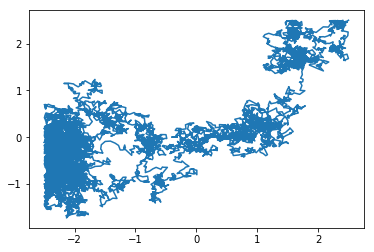

In [25]:
plt.plot(path[:,0],path[:,1])

In [26]:
def plot_solstad(path, func, arena=(5,5)):
    x   = path[:,0]
    y   = path[:,1]

    # set up a list of (x,y) points
    points = np.array([x,y]).transpose().reshape(-1,1,2)
    # set up a list of segments
    segs = np.concatenate([points[:-1],points[1:]],axis=1)
    # make the collection of segments
    lc = LineCollection(segs, cmap=plt.get_cmap('jet'))
    lc.set_array(func) # color the segments by our parameter

    # plot the collection
    plt.figure()
    plt.gca().add_collection(lc) # add the collection to the plot
    plt.xlim(-arena[0], arena[0]) # line collections don't auto-scale the plot
    plt.ylim(-arena[1], arena[1])

In [27]:
psi_w = psi(2,0,xy,np.array([0,0]))

In [28]:
psi_w_2 = psi(2,0,xy,np.array([2.2,0]))

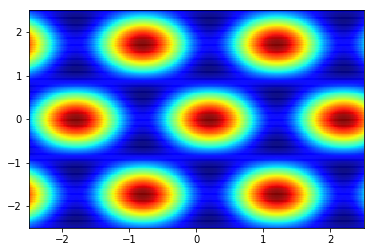

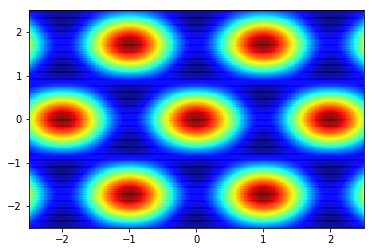

In [29]:
plot_solstad(xy,psi_w_2,(2.5,2.5)); plot_solstad(xy,psi_w,(2.5,2.5))

## Creating place cells from these grid cells

In [20]:
def solstad_weights(lambda_low, lambda_up, sigma, N):
    lam = np.arange(lambda_low,lambda_up,0.01)
    dist_constants = (2 * np.pi * sigma**2) * ((2*np.pi)/N) * np.log(lambda_up/lambda_low)
    dist = dist_constants * np.exp((-4.0/3)* np.pi**2 * sigma**2 / lam**2) / lam**2
    pdf = dist/np.sum(dist)
    weights = nprd.choice(dist,size=N,p=pdf)
    return weights
    